## Kassandra model training 

###  Disclaimer: This is an example of the Kassandra deconvolution algorithm training described in the original publication (link). To use model training  with a reasonable amount of computing power, we have provided a smaller version of the model with the subset of data used in the publication. However, model training still requires significant computational resources (4 cores, ~30gb RAM). The performance of the model will differ from the version published. The example shared is solely for educational purposes.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image
from core.mixer import Mixer
from core.cell_types import CellTypes
from core.model import DeconvolutionModel
from core.plotting import print_cell_matras, cells_p, print_all_cells_in_one
from core.utils import *

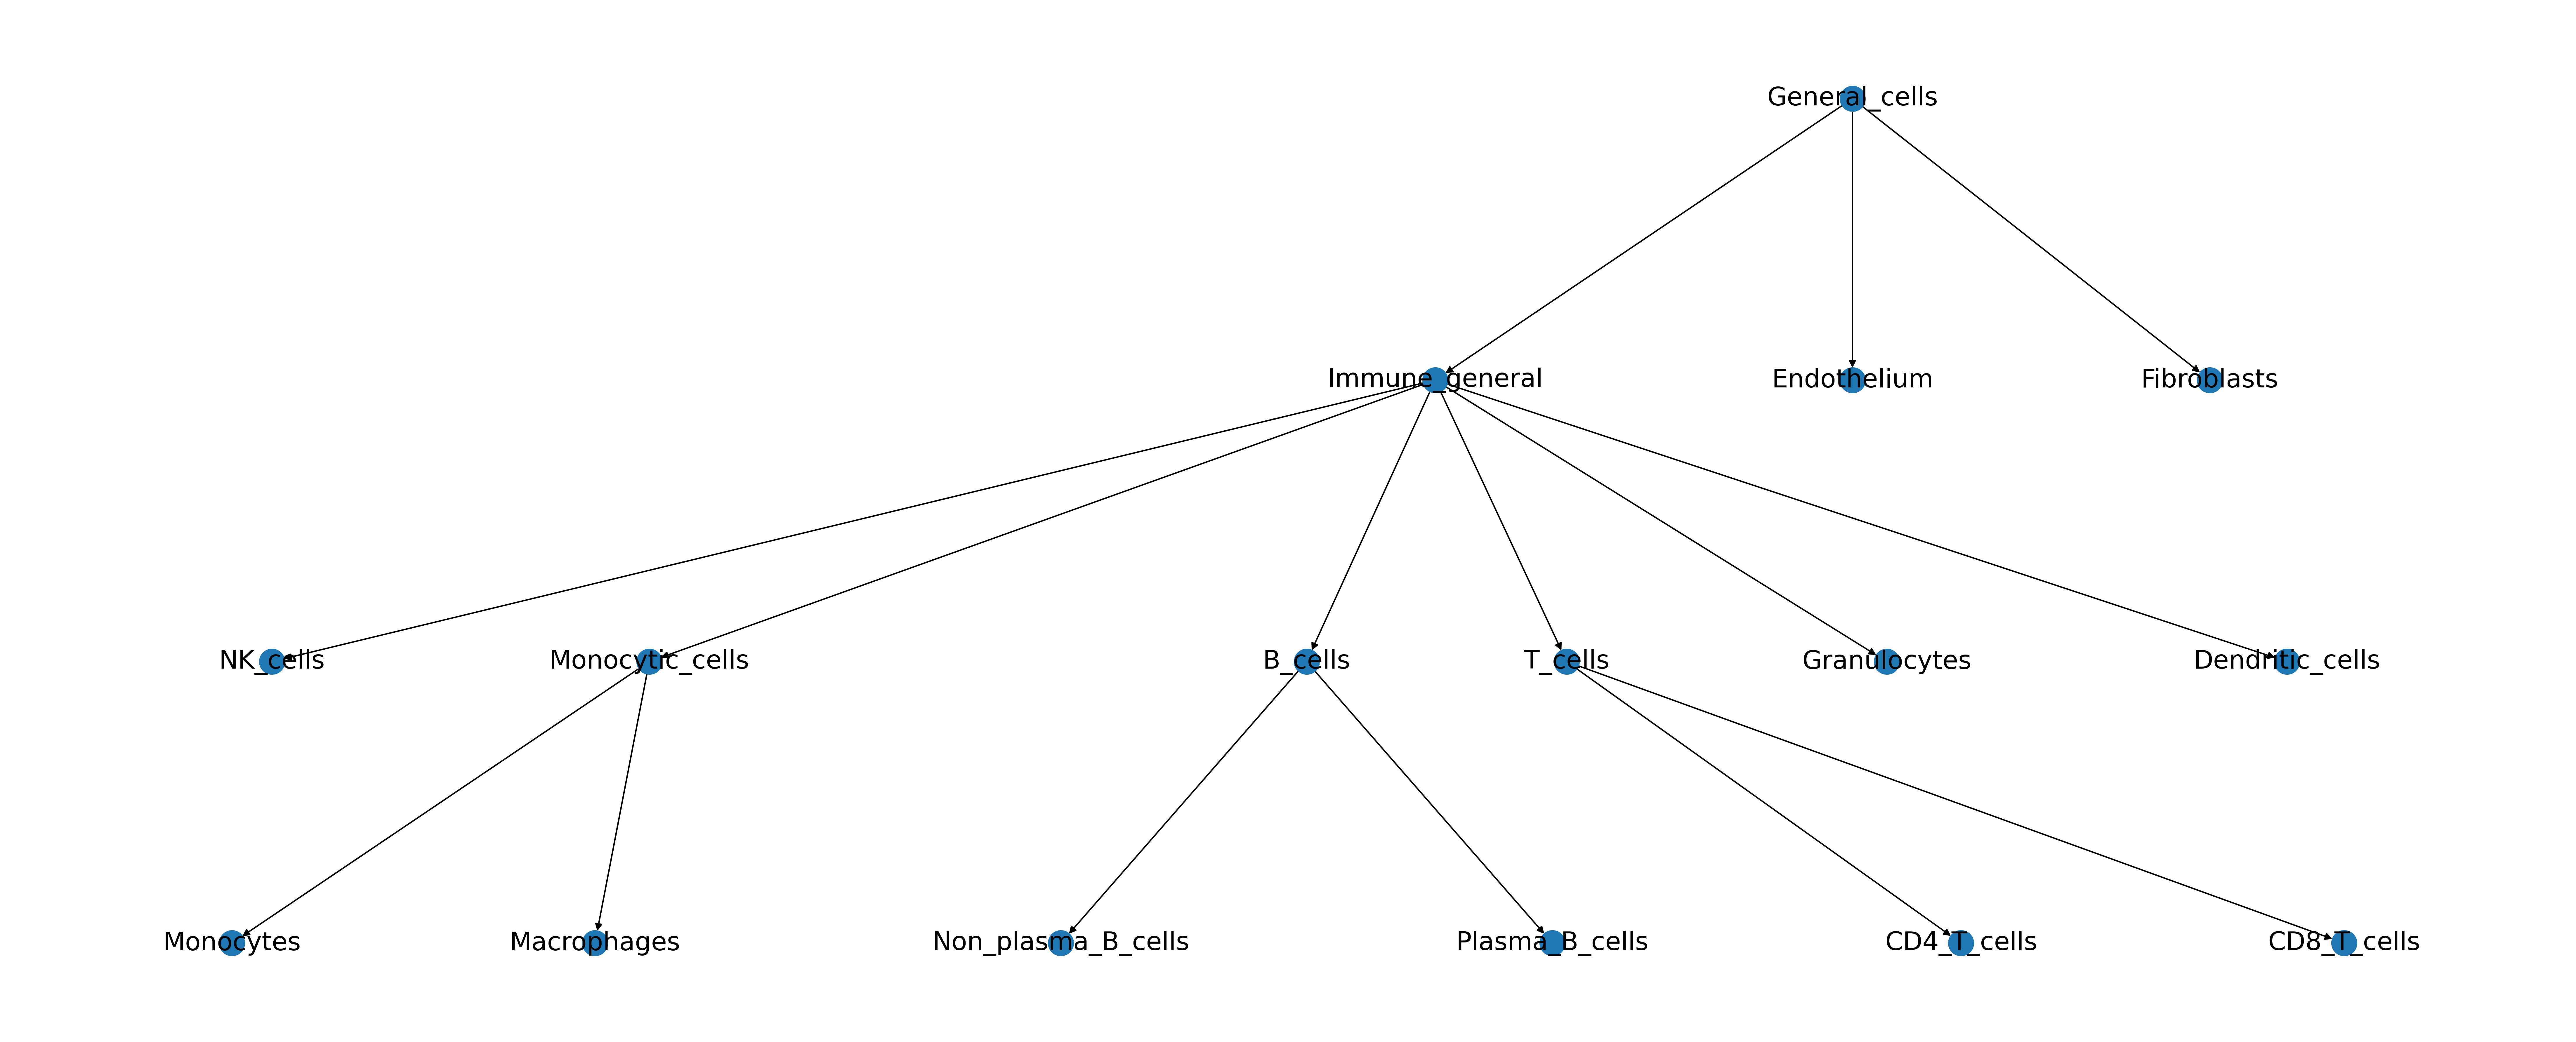

In [2]:
Image(filename='data/tree.png')

In [2]:
cancer_sample_annot = pd.read_csv('data/cancer_samples_annot.tsv.tar.gz', sep='\t', index_col=0)
cancer_expr = pd.read_csv('data/cancer_expr.tsv.tar.gz', sep='\t', index_col=0)
cells_sample_annot = pd.read_csv('data/cells_samples_annot.tsv.tar.gz', sep='\t', index_col=0)
cells_expr = pd.read_csv('data/cells_expr.tsv.tar.gz', sep='\t', index_col=0)

In [3]:
# Pseudobulk generation
cell_types = CellTypes.load('configs/cell_types.yaml')
mixer = Mixer(cell_types=cell_types,
              cells_expr=cells_expr, cells_annot=cells_sample_annot,
              tumor_expr=cancer_expr, tumor_annot=cancer_sample_annot,
              num_av=3, num_points=30)
expr, values = mixer.generate('Immune_general')
values

Checking normal cells expressions...
Expressions OK
Checking cancer cells expressions...
Expressions OK


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Endothelium,0.444239,0.208984,0.113030,0.023730,0.068007,0.055623,0.084111,0.003896,0.024088,0.000649,...,0.270106,0.113767,0.078344,0.067541,0.020192,0.426928,0.002106,0.650749,0.095187,0.097072
Fibroblasts,0.161942,0.217086,0.026622,0.260578,0.469791,0.062486,0.089715,0.000728,0.421257,0.001805,...,0.299657,0.026506,0.189385,0.311536,0.013997,0.001479,0.001325,0.003382,0.021014,0.040656
Immune_general,0.077720,0.201773,0.379953,0.053445,0.105026,0.063268,0.265154,0.581890,0.229074,0.001003,...,0.401432,0.115907,0.381287,0.131455,0.147157,0.096417,0.036730,0.202335,0.058437,0.296492
Tumor,0.316099,0.372157,0.480395,0.662246,0.357175,0.818624,0.561020,0.413486,0.325581,0.996543,...,0.028805,0.743821,0.350985,0.489468,0.818654,0.475175,0.959839,0.143533,0.825363,0.565781


In [4]:
# Model training
mixer = Mixer(cell_types=cell_types,
              cells_expr=cells_expr, cells_annot=cells_sample_annot,
              tumor_expr=cancer_expr, tumor_annot=cancer_sample_annot,
              num_av=3, num_points=30000)

model = DeconvolutionModel(cell_types,
                           boosting_params_first_step='configs/boosting_params/lgb_parameters_first_step.tsv',
                           boosting_params_second_step='configs/boosting_params/lgb_parameters_second_step.tsv')
model.fit(mixer)

Checking normal cells expressions...
Expressions OK
Checking cancer cells expressions...
Expressions OK
============== L1 models ==============
Generating mixes for B_cells model
Fitting B_cells model
Trained in:  2.1 sec.


Generating mixes for CD4_T_cells model
Fitting CD4_T_cells model
Trained in:  2.6 sec.


Generating mixes for CD8_T_cells model
Fitting CD8_T_cells model
Trained in:  4.0 sec.


Generating mixes for Dendritic_cells model
Fitting Dendritic_cells model
Trained in:  2.2 sec.


Generating mixes for Endothelium model
Fitting Endothelium model
Trained in:  4.3 sec.


Generating mixes for Fibroblasts model
Fitting Fibroblasts model
Trained in:  13.9 sec.


Generating mixes for Granulocytes model
Fitting Granulocytes model
Trained in:  2.4 sec.


Generating mixes for Immune_general model
Fitting Immune_general model
Trained in:  10.3 sec.


Generating mixes for Macrophages model
Fitting Macrophages model
Trained in:  5.9 sec.


Generating mixes for Monocytes model
Fitting 

Expressions OK


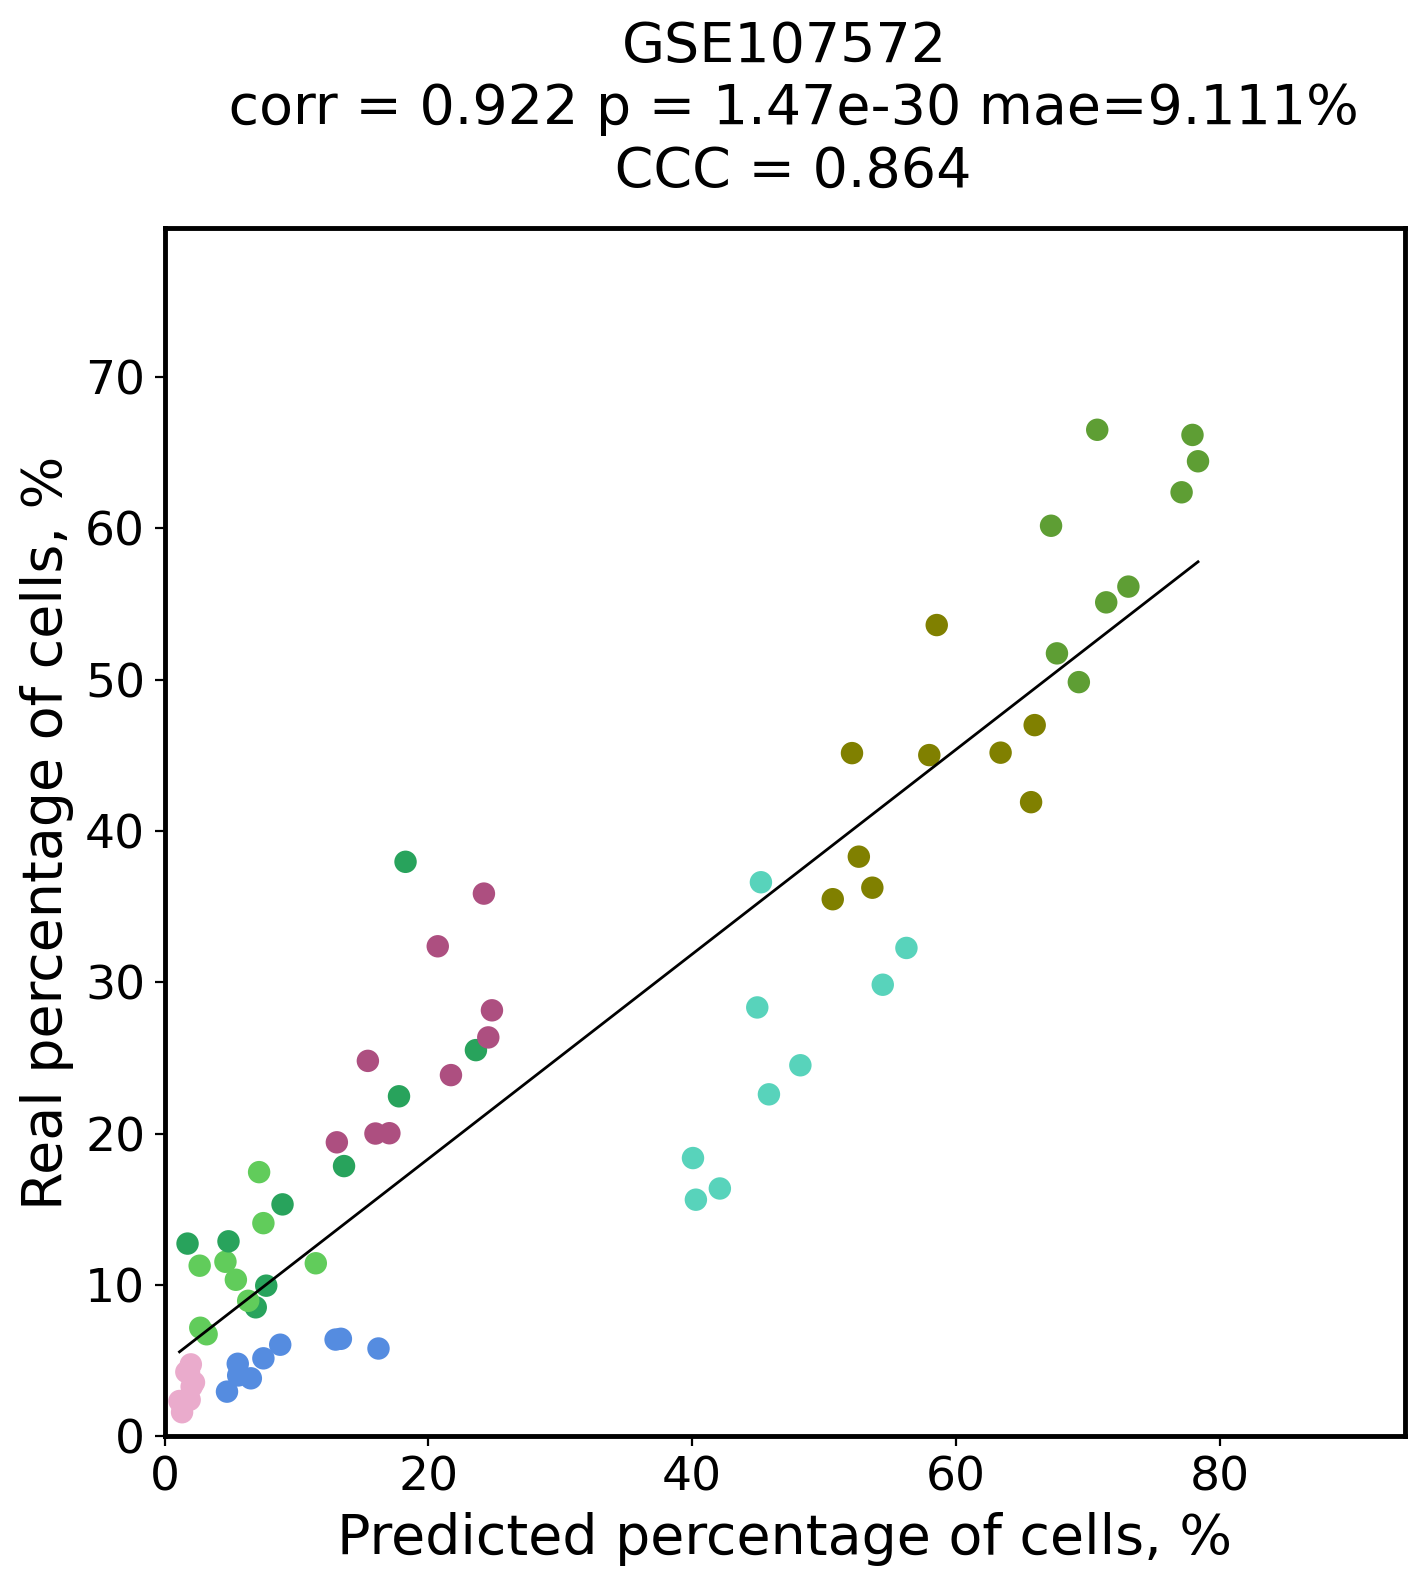

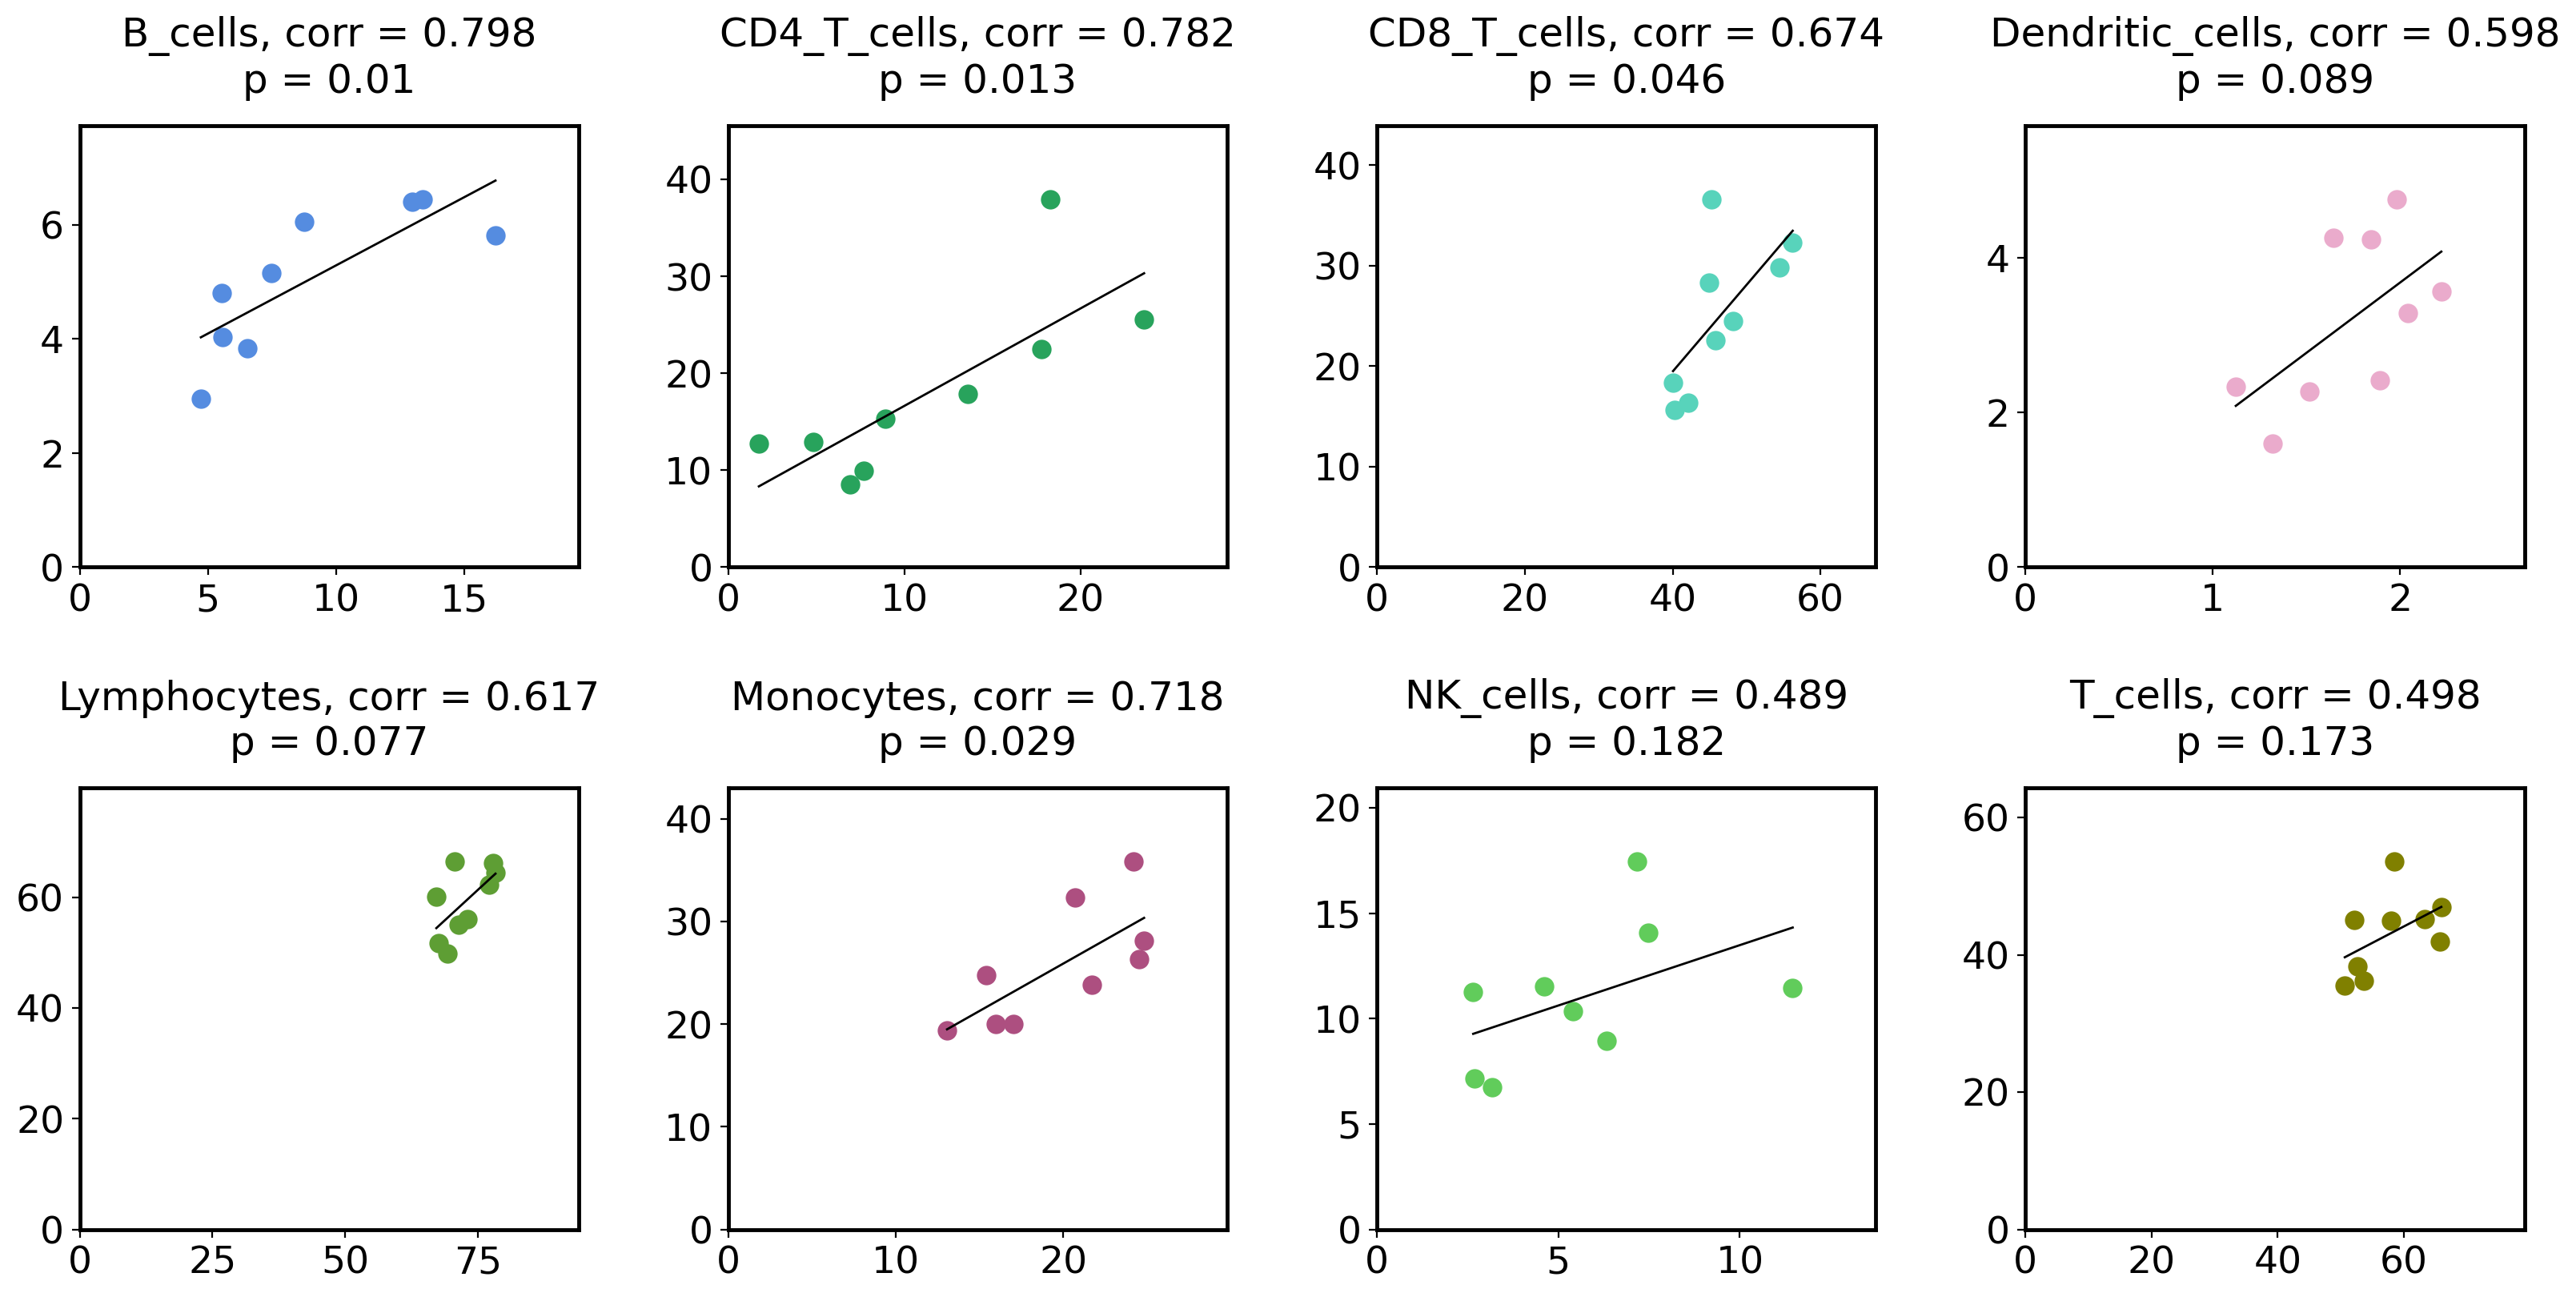

In [10]:
# Performance testing
dataset = 'GSE107572'
cytof = pd.read_csv('data/GSE107572_cytof.tsv.tar.gz', sep='\t', index_col=0)
expr = pd.read_csv('data/GSE107572_expr.tsv.tar.gz', sep='\t', index_col=0)

preds = model.predict(expr) * 100
preds.loc['Lymphocytes'] = preds.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

plt.rcParams['figure.dpi'] = 200
plt.rcParams["axes.edgecolor"] = "0.0"
plt.rcParams["axes.linewidth"]  = 1.75

x = print_all_cells_in_one(preds, 
                           cytof,
                           pallete=cells_p,
                           title=dataset, min_xlim=0, min_ylim=0)

x = print_cell_matras(preds, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='', predicted_name='',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=4, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)

Expressions OK


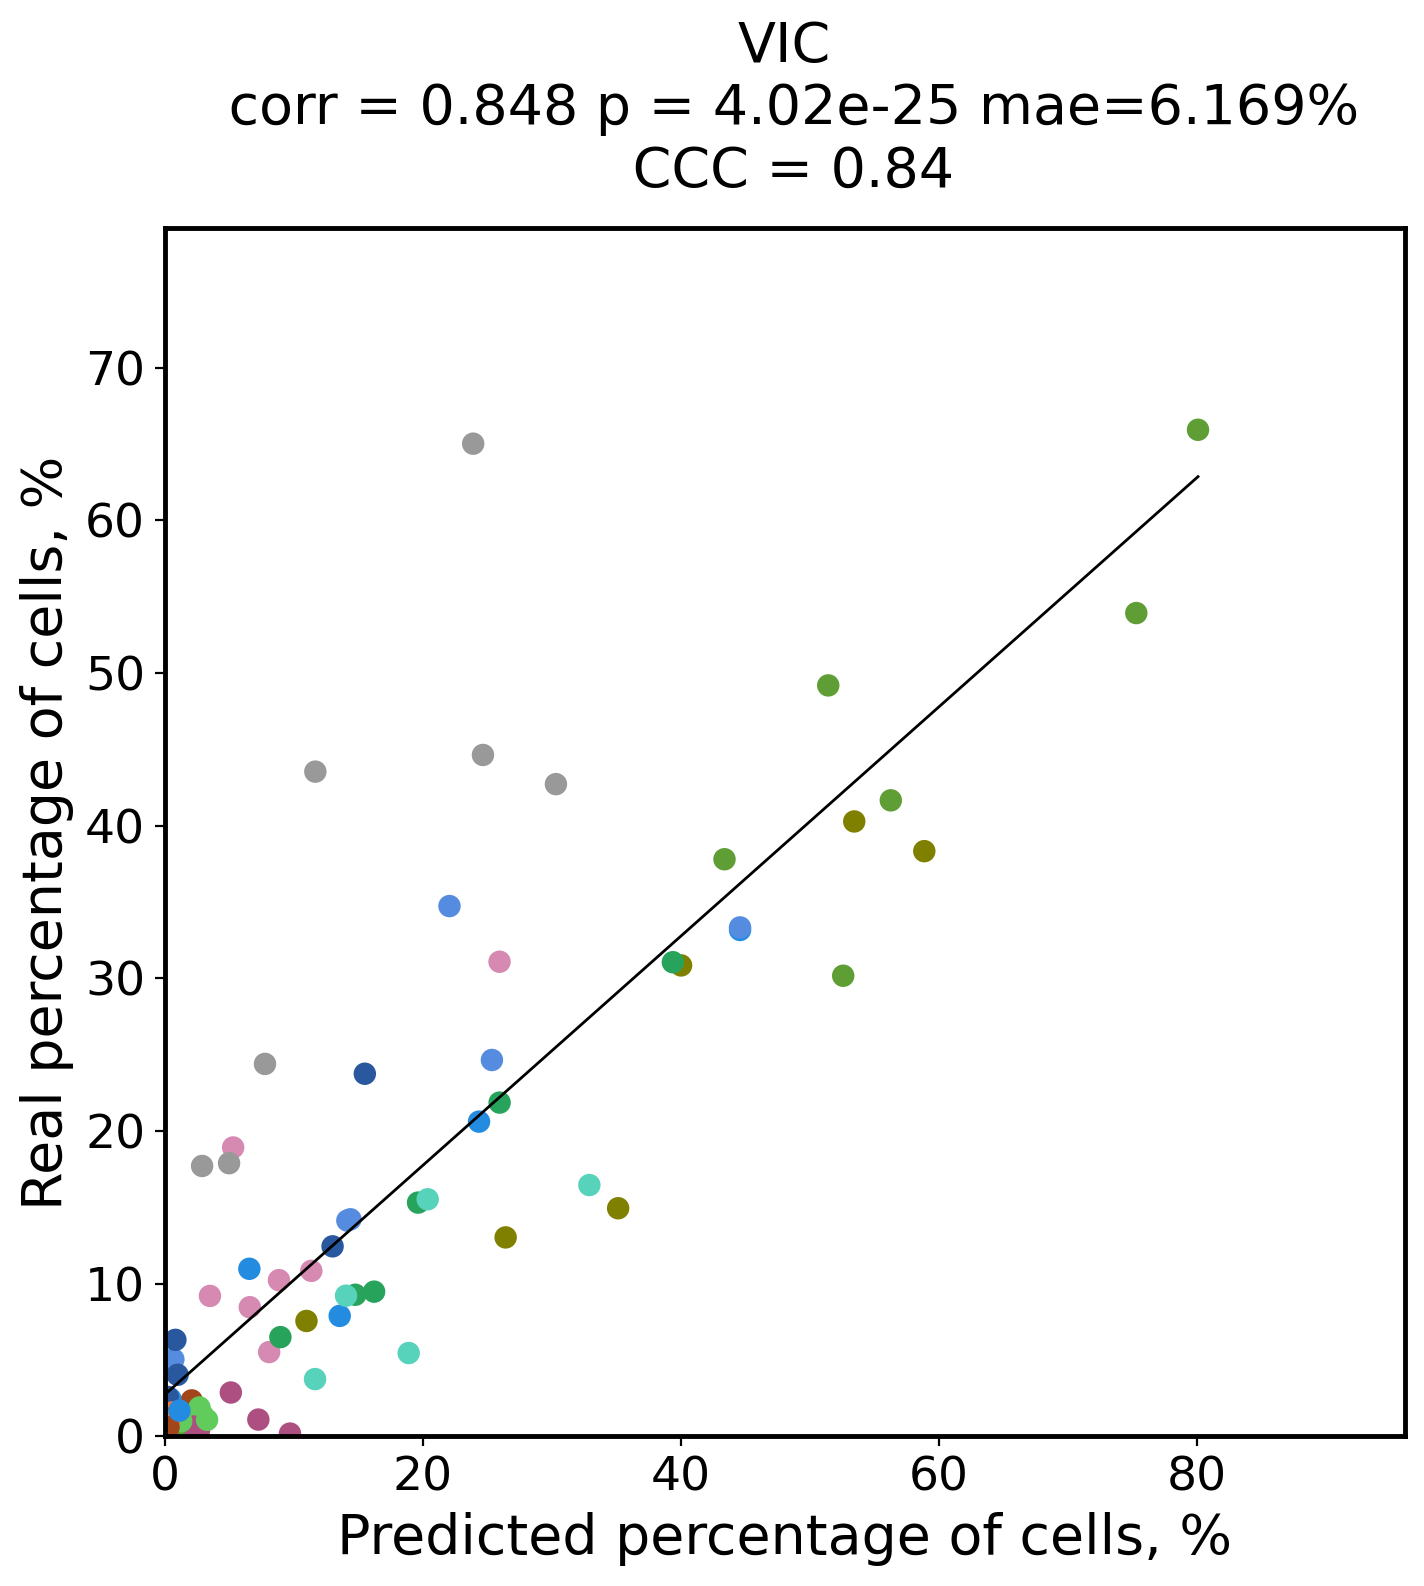

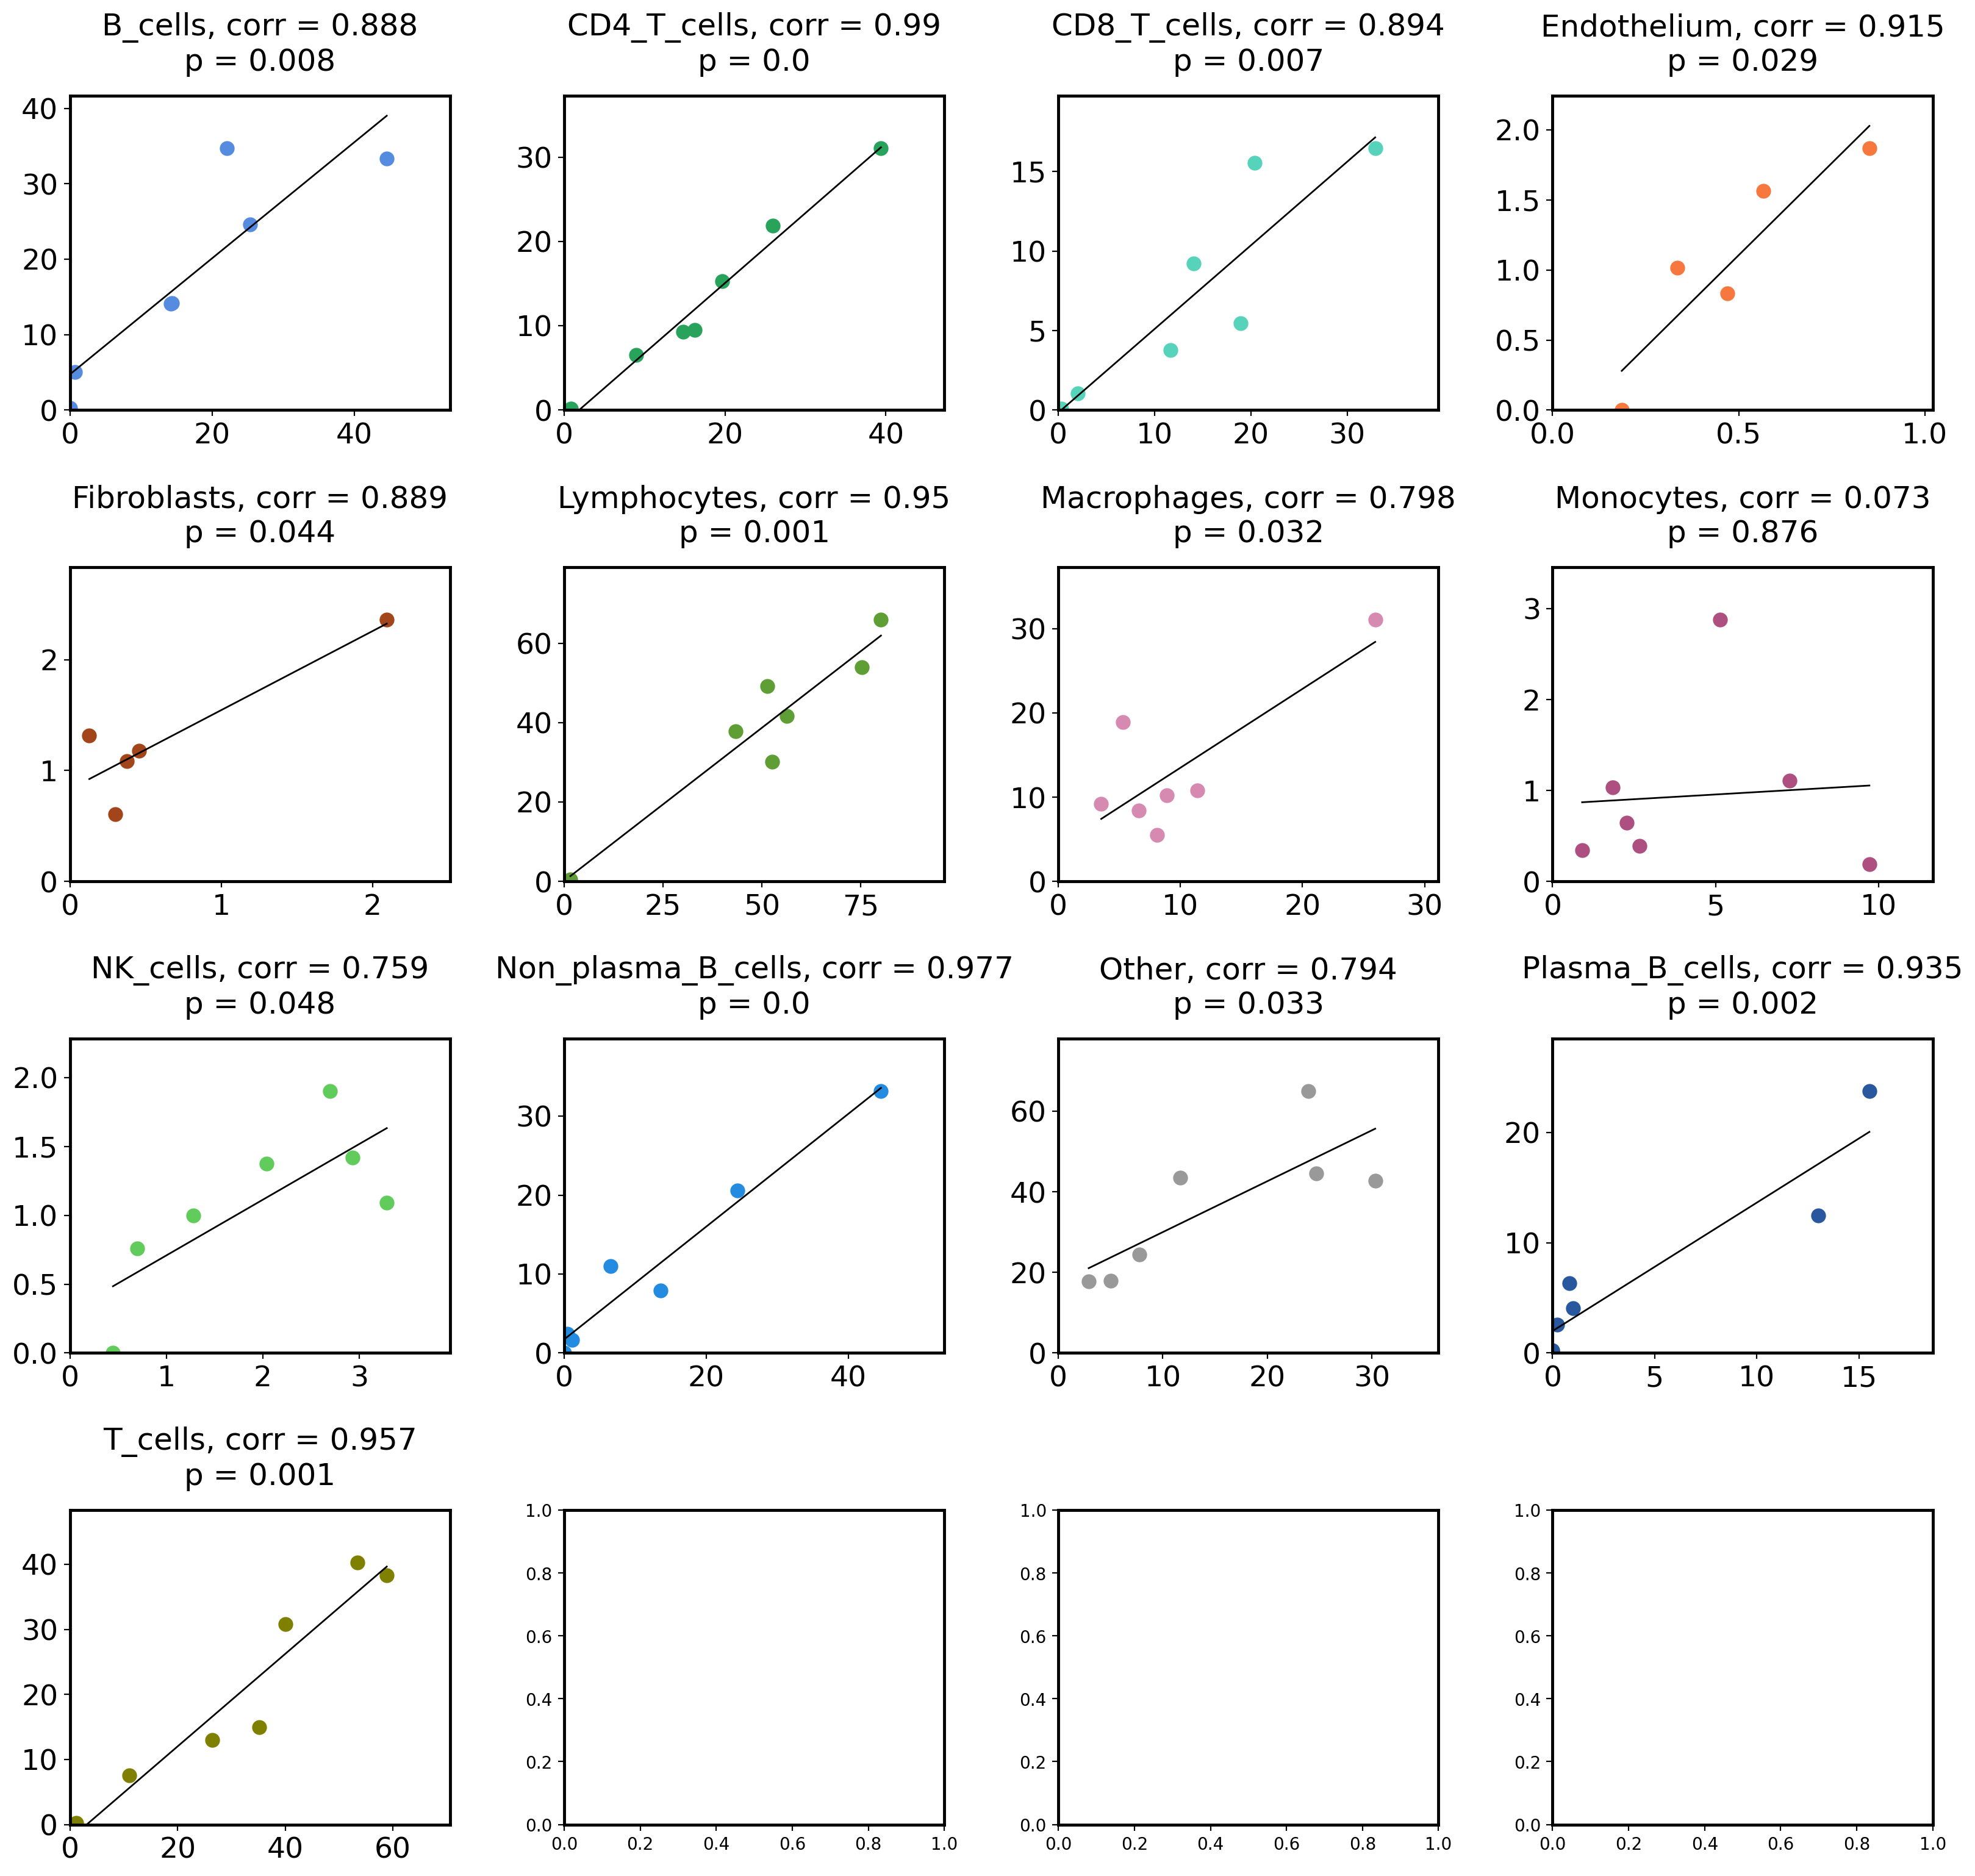

In [13]:
dataset = 'VIC'
cytof = pd.read_csv('data/VIC_cytof.tsv.tar.gz', sep='\t', index_col=0)
expr = pd.read_csv('data/VIC_expr.tsv.tar.gz', sep='\t', index_col=0)

preds = model.predict(expr) * 100
preds.loc['Lymphocytes'] = preds.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

plt.rcParams['figure.dpi'] = 200
plt.rcParams["axes.edgecolor"] = "0.0"
plt.rcParams["axes.linewidth"]  = 1.75

x = print_all_cells_in_one(preds, 
                           cytof,
                           pallete=cells_p,
                           title=dataset, min_xlim=0, min_ylim=0)

x = print_cell_matras(preds, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='', predicted_name='',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=4, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)

Expressions OK


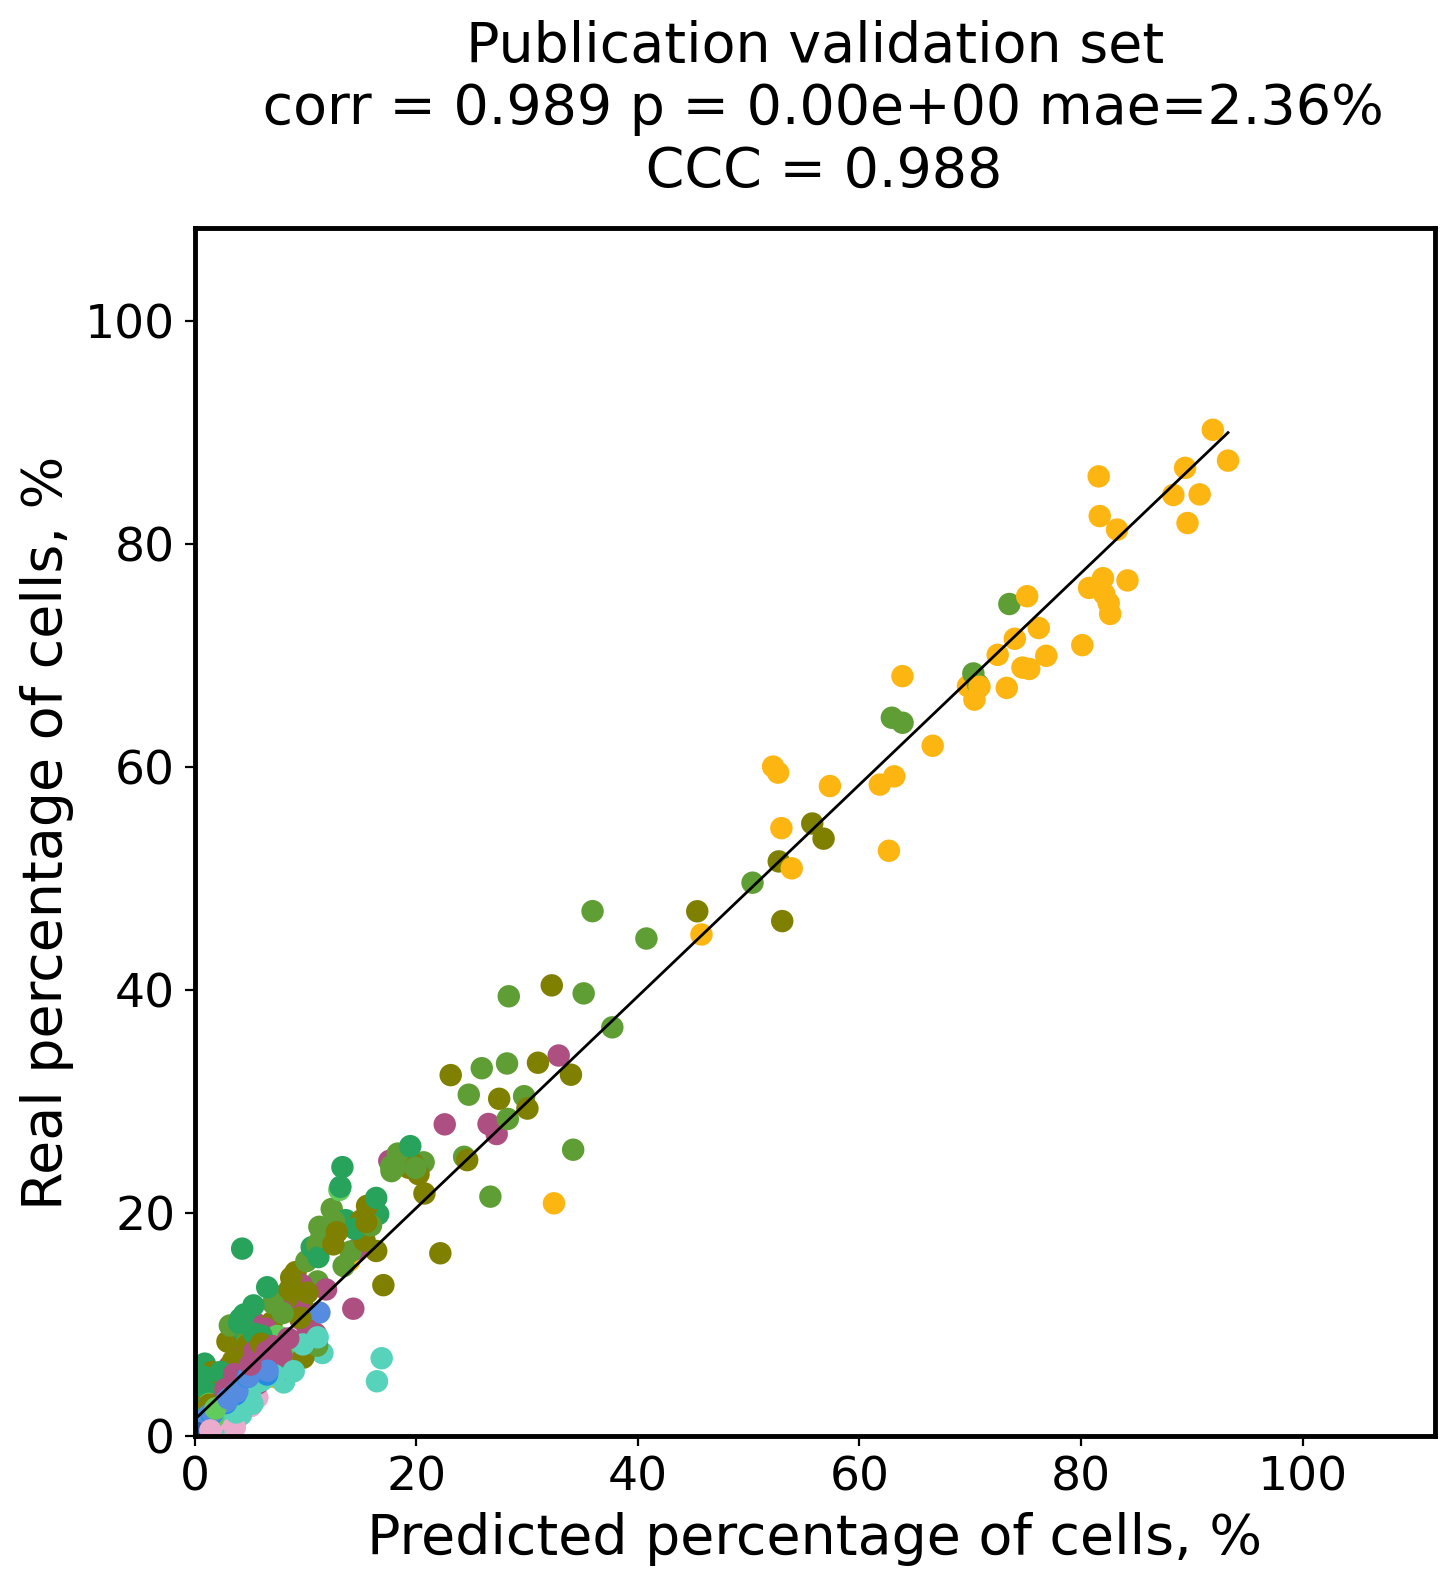

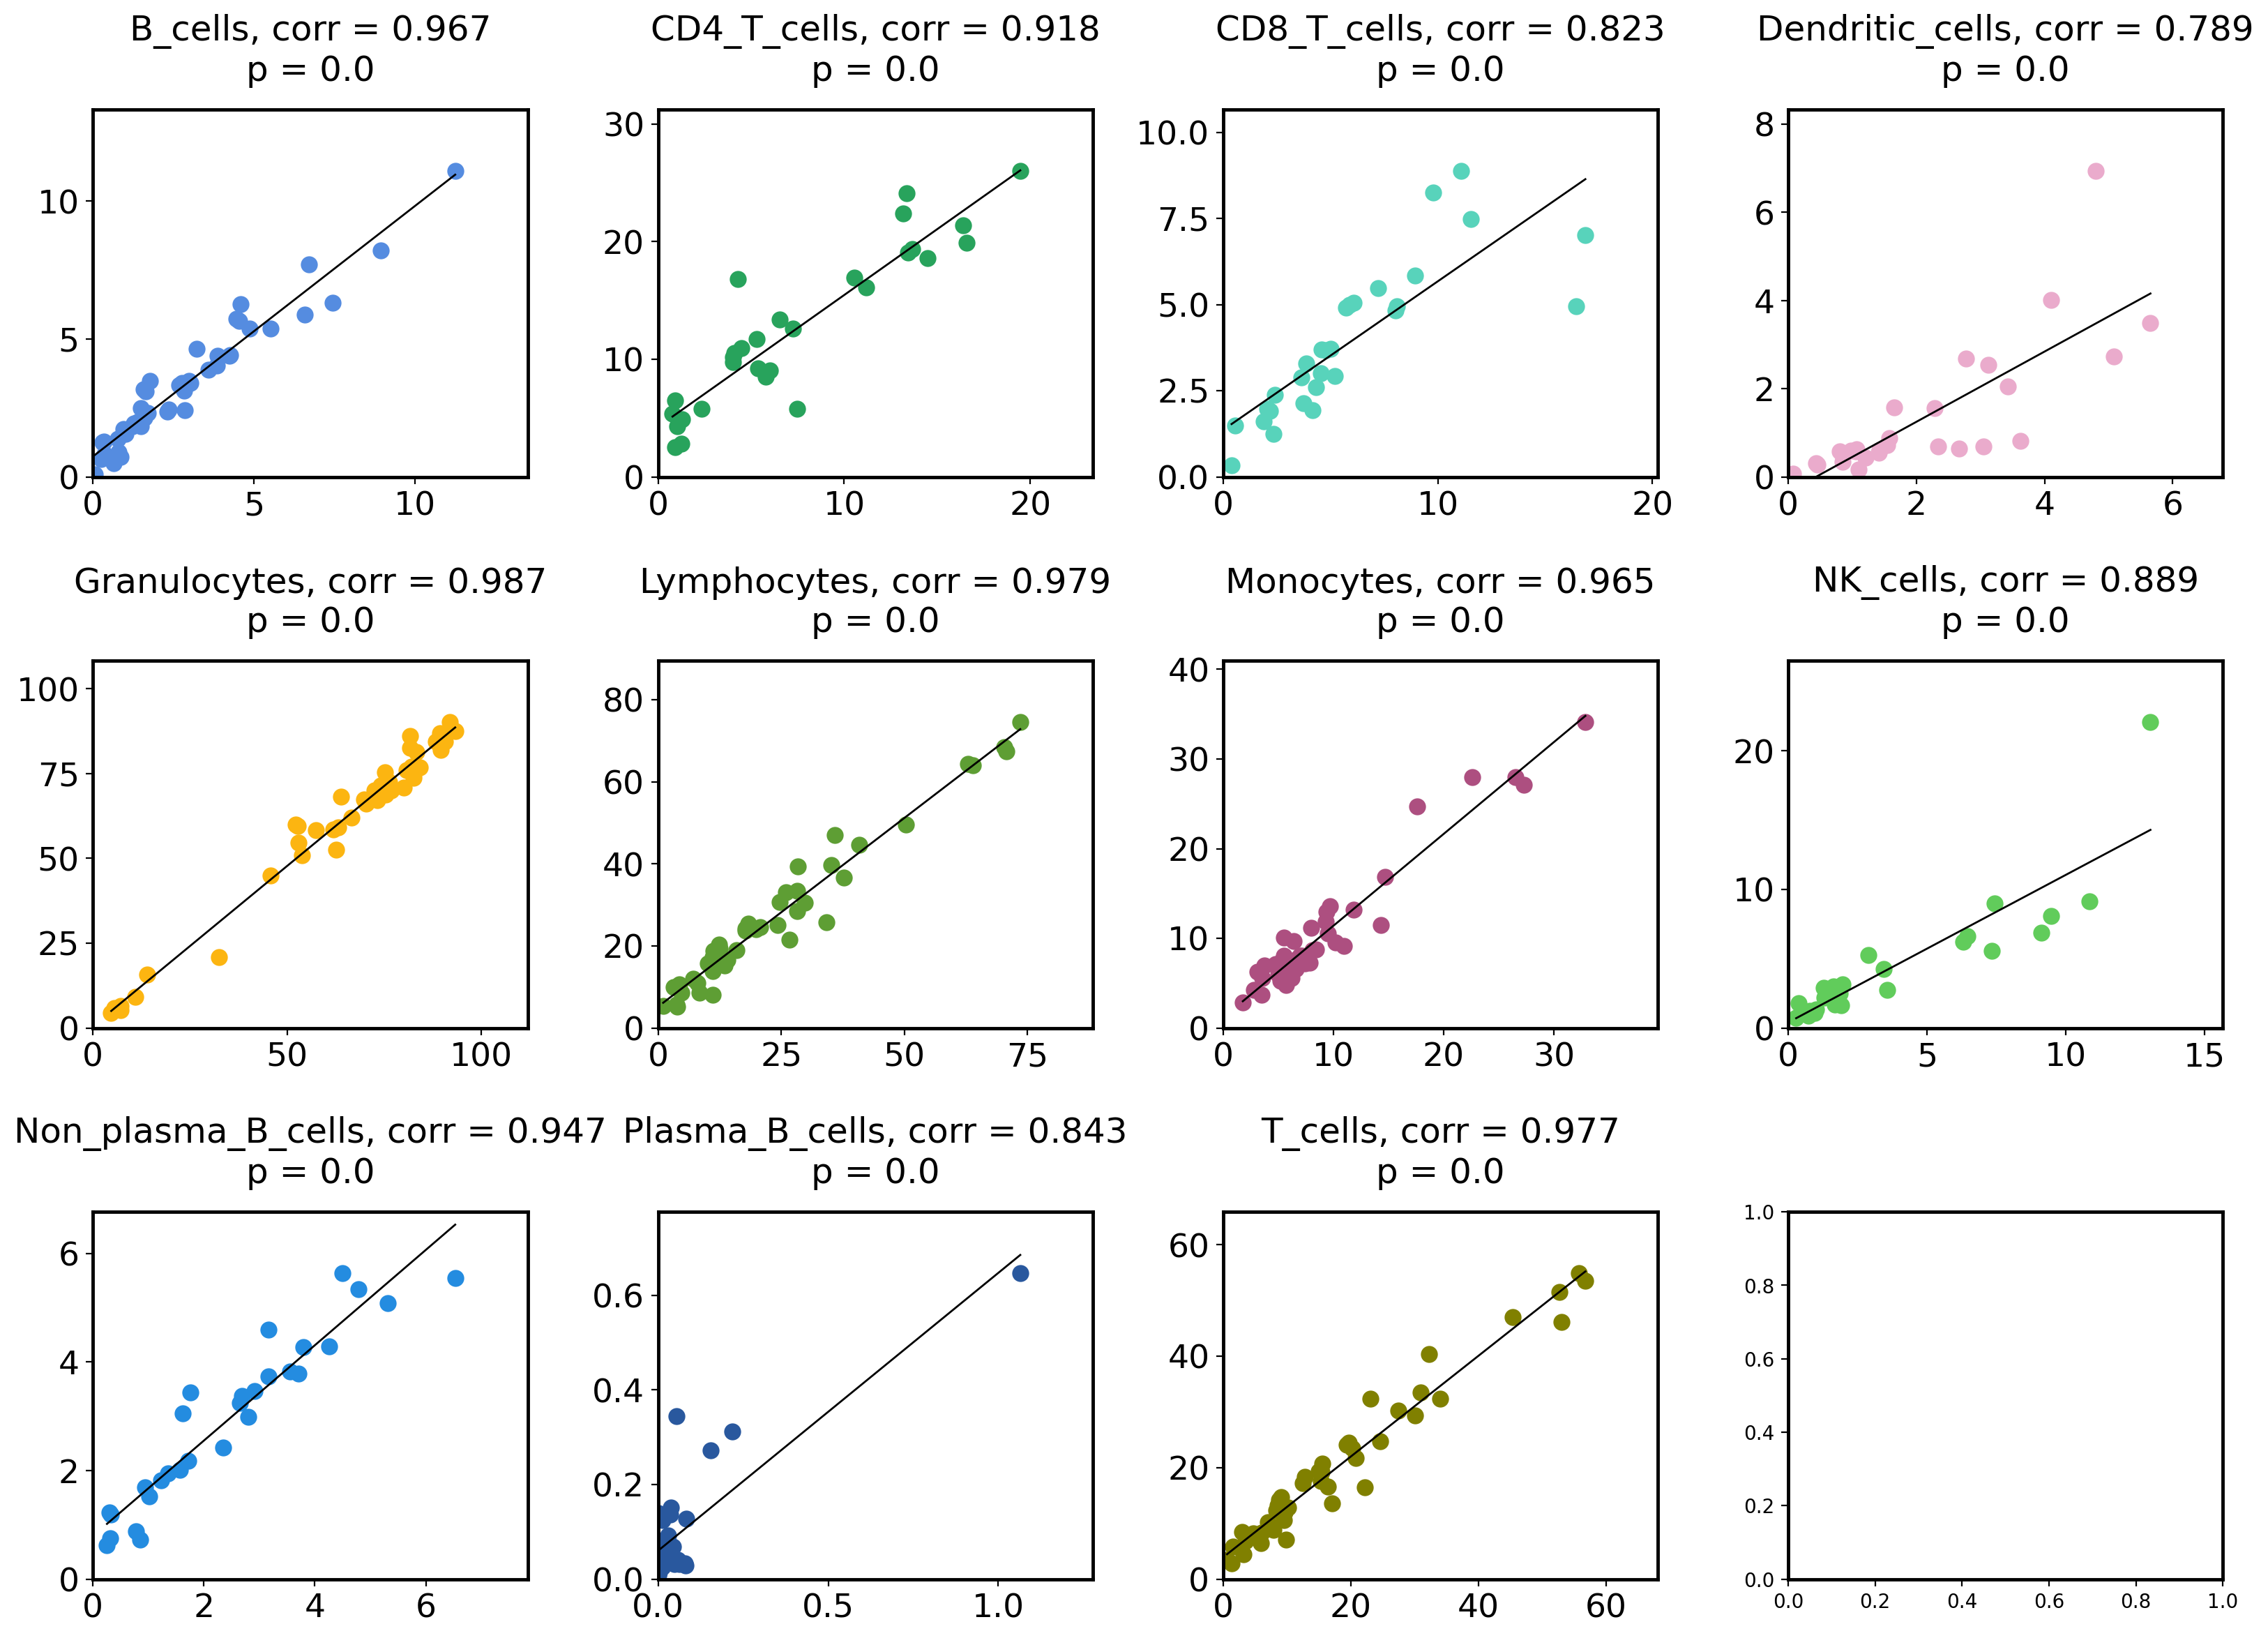

In [14]:
dataset = 'Publication validation set'
cytof = pd.read_csv('data/validation_datasets/cytometry_df.tsv', sep='\t', index_col=0)
expr = pd.read_csv('data/validation_datasets/blood_expr.tsv', sep='\t', index_col=0)

preds = model.predict(expr) * 100
preds.loc['Lymphocytes'] = preds.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

plt.rcParams['figure.dpi'] = 200
plt.rcParams["axes.edgecolor"] = "0.0"
plt.rcParams["axes.linewidth"]  = 1.75

x = print_all_cells_in_one(preds, 
                           cytof,
                           pallete=cells_p,
                           title=dataset, min_xlim=0, min_ylim=0)

x = print_cell_matras(preds, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='', predicted_name='',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=4, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)

In [15]:
# Transcripts to genes for publication tumor model
expr = pd.read_csv('/home/bshpak/Kassandra/data/transcript_example.tsv.gz', sep='\t', index_col=0)
expr = tr_to_genes(expr, tr_ids_path='/home/bshpak/Kassandra/data/tumor_model_transcripts.txt')
expr = renorm_expressions(expr, 'data/genes_in_expression.txt')
expr

,210526_NovaB_Sample_17,210526_NovaB_Sample_3,210526_NovaB_Sample_21,210526_NovaB_Sample_31,210526_NovaB_Sample_25
Gene,,,,,
SOX6,2.633860,3.998889,2.396200,1.039560,1.846927
C5orf30,2.622363,1.993186,1.964706,1.350983,1.869960
LSM8,41.397966,37.493214,24.712070,28.471749,28.403895
LSM6,36.045414,44.110654,32.143073,54.294296,31.450004
PCDHB1,0.476215,0.628231,0.268965,0.351781,0.630217
...,...,...,...,...,...
ERO1LB,10.930841,11.037704,6.956258,12.745525,8.195557
H3F3A,2026.294404,2526.243288,3414.225671,3572.400458,2914.203553
GSN,177.689326,136.163056,179.314878,191.843136,180.365275


In [16]:
# transcripts to genes for publication blood model 
expr = pd.read_csv('/home/bshpak/Kassandra/data/transcript_example.tsv.gz', sep='\t', index_col=0)
expr = tr_to_genes(expr, tr_ids_path='/home/bshpak/Kassandra/data/blood_model_transcripts.txt')
expr = renorm_expressions(expr, 'data/genes_in_expression.txt')
expr

,210526_NovaB_Sample_17,210526_NovaB_Sample_3,210526_NovaB_Sample_21,210526_NovaB_Sample_31,210526_NovaB_Sample_25
Gene,,,,,
SOX6,0.088183,0.042267,0.054817,0.019374,0.220611
C5orf30,3.585971,2.785621,2.628282,1.856798,2.561177
LSM8,56.609983,52.399457,33.058526,39.131725,38.903173
LSM6,6.377649,8.603601,4.692696,8.308001,3.768249
PCDHB1,0.651204,0.877998,0.359807,0.483489,0.863171
...,...,...,...,...,...
ERO1LB,14.947467,15.425984,9.305722,17.517518,11.224981
H3F3A,2770.872617,3530.606283,4567.374104,4909.926344,3991.416165
GSN,225.787831,173.766304,228.185571,248.595435,238.132607
